# Projeto 1

Aluno: <span style="color:red">Nicolas Enzo Yassuda</span>

Entrega: 16 de maio de 2024

Neste projeto você vai construir um modelo de regressão sobre um dataset de notas finais de alunos do ensino fundamental em relação a parâmetros socio-ambientais dos mesmos. O dataset foi obtido de 
https://archive.ics.uci.edu/dataset/320/student+performance.

## Descrição do projeto

O projeto tem duas partes: modelagem inicial, e modelo com filtragem dos dados.

### Fase 1 

Na parte inicial, você deverá:

- Realizar *feature engineering* conforme necessário
    - Por exemplo: codificar as variáveis categóricas com `OneHotEncoding`
    - Não remova *outliers* aqui: faremos isso na seção seguinte
- Construir três modelos de regressão:
    - Um modelo usando o regressor `DummyRegressor` do scikit-learn (https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html) que vai servir de "regressor trivial" para nós.
    - Um modelo `Ridge`.
    - Um outro modelo qualquer à sua escolha.
    Como o professor é santo, os dois primeiros já estão implementados para você! Então só falta escolher o terceiro.
- Fazer o ajuste de hiperparâmetros dos modelos. O código de exemplo já mostra como fazer o ajuste dos modelos iniciais, você especifica o grid de parâmetros de teste para o seu terceiro modelo.
- Comparar os desempenhos de modelos de modo adequado. Estude o material em https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html para saber como fazer o teste t com compensação de correlação dos desempenhos dos modelos em um cenário de validação cruzada.
- Escolhido o melhor modelo, treiná-lo no conjunto de treinamento e medir o desempenho no
conjunto de teste, para estimar o desempenho de generalização do modelo.
- Escrever suas conclusões à respeito do que foi aprendido acerta do modelo, por exemplo:
    - Quais as consequências do desempenho do modelo final para a estimação das notas finais?
    - Quais features são mais importantes na determinação da estimativa da nota final? Note que essa pergunta pode ou não ter resposta, dependendo das capacidades dos modelos de regressão que você escolher.

### Fase 2

Agora execute uma filtragem dos dados de treinamento para remover valores anormais. Por exemplo:

- Remova os alunos que tiveram nota final zero
- Remova os alunos que faltaram muito - defina você mesmo o que é "faltar muito"

Refaça o processo da fase 1 para esses dados filtrados.

### Rubrica

Os itens a serem avaliados no projeto são:

FEAT – Fazer feature engineering adequadamente

HYPER – Para cada modelo, fez ajuste de hiperparâmetros adequadamente

MODEL – Treinou e comparou adequadamente os modelos para selecionar o melhor modelo

PERF – Análise de desempenho do modelo. NÃO SERÁ EXIGIDA NENHUMA PERFORMANCE ESPECÍFICA, ISTO NÃO É UMA COMPETIÇÃO DE DESEMPENHO.

FILT - Executar a fase 2: filtragem de dados adequada e repetição do experimento.

- I – Insuficiente

    - Não entregou, ou entregou abobrinha

- D – Em desenvolvimento

    - Faltou um de FEAT, MODEL, PERF

- C – Minimo aceitável

    - Fez FEAT, MODEL, PERF

- B – Esperado

    - Fez FEAT, HYPER, MODEL, PERF

- A – Excepcional

    - Fez FEAT, HYPER, MODEL, PERF, FILT


# Inicio do projeto

## Leitura dos dados e correção de tipos de dados

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

In [3]:
DATA_DIR = Path.cwd()

In [4]:
def load_data(data_dir: Path = DATA_DIR) -> pd.DataFrame:
    # Read data and fix column types.
    df = pd.read_csv(data_dir / 'data.csv')

    categorical_columns = [
        'school',
        'sex',
        'address',
        'famsize',
        'Pstatus',
        'Mjob',
        'Fjob',
        'reason',
        'guardian',
        'schoolsup',
        'famsup',
        'paid',
        'activities',
        'nursery',
        'higher',
        'internet',
        'romantic',
    ]
    numerical_columns = [
        'age',
        'absences',
        'grade',
    ]
    ordinal_columns = [
        'Medu',
        'Fedu',
        'traveltime',
        'studytime',
        'failures',
        'famrel',
        'freetime',
        'goout',
        'Dalc',
        'Walc',
        'health',
    ]
    for column_group, column_type in (
        (categorical_columns, 'category'),
        (numerical_columns, 'float64'),
        (ordinal_columns, 'int64'),
    ):
        for column in column_group:
            df[column] = df[column].astype(column_type)

    # Split features and target, and return.
    X = df.drop(columns=['grade']).copy()
    y = df['grade'].copy()
    return X, y

In [5]:
X, y = load_data()

## Visualização simples dos dados

Chamar isso de análise exploratória é vexatório...

In [6]:
def make_barplots(X: pd.DataFrame, y: pd.Series) -> None:
    fig, axes = plt.subplots(10, 3, figsize=(12, 45))
    axes = axes.flatten()

    fig.tight_layout(h_pad=8, w_pad=5)

    for index, (column_name, column_series) in enumerate(X.items()):
        column_series \
            .value_counts() \
            .sort_index(ascending=False) \
            .plot \
            .barh(ax=axes[index])
        axes[index].set_title(column_name)

    fig.suptitle('Barplots of Categorical and Ordinal Features', fontsize=16)
    fig.subplots_adjust(top=0.96)
    plt.show()

    plt.figure(figsize=(3, 4))
    y.plot.hist(bins=20, edgecolor='black')
    plt.title('Histogram of Target')
    plt.show()
    

In [7]:
def make_boxplots(X: pd.DataFrame, y: pd.Series) -> None:
    df = pd.concat([X, y], axis=1)

    fig, axes = plt.subplots(10, 3, figsize=(12, 45))
    axes = axes.flatten()

    fig.tight_layout(h_pad=8, w_pad=5)

    for index, column in enumerate(X.columns):
        ax = axes[index]
        bp_objs = df.boxplot(
            by=['school', column],
            column='grade',
            ax=ax,
            rot=45,
            fontsize=8,
            return_type='dict',
            patch_artist=True,
        )
        boxes = bp_objs['grade']['boxes']
        box_colors = [
            'lightgreen' if '(GP,' in tick.get_text() else 'lightblue'
            for tick in ax.get_xticklabels()
        ]
        for box, color in zip(boxes, box_colors):
            box.set_facecolor(color)
        ax.set_title(column)
        ax.set_xlabel('')
    fig.suptitle('Grade distribution by feature and school', fontsize=16)
    fig.subplots_adjust(top=0.96)
    plt.show()

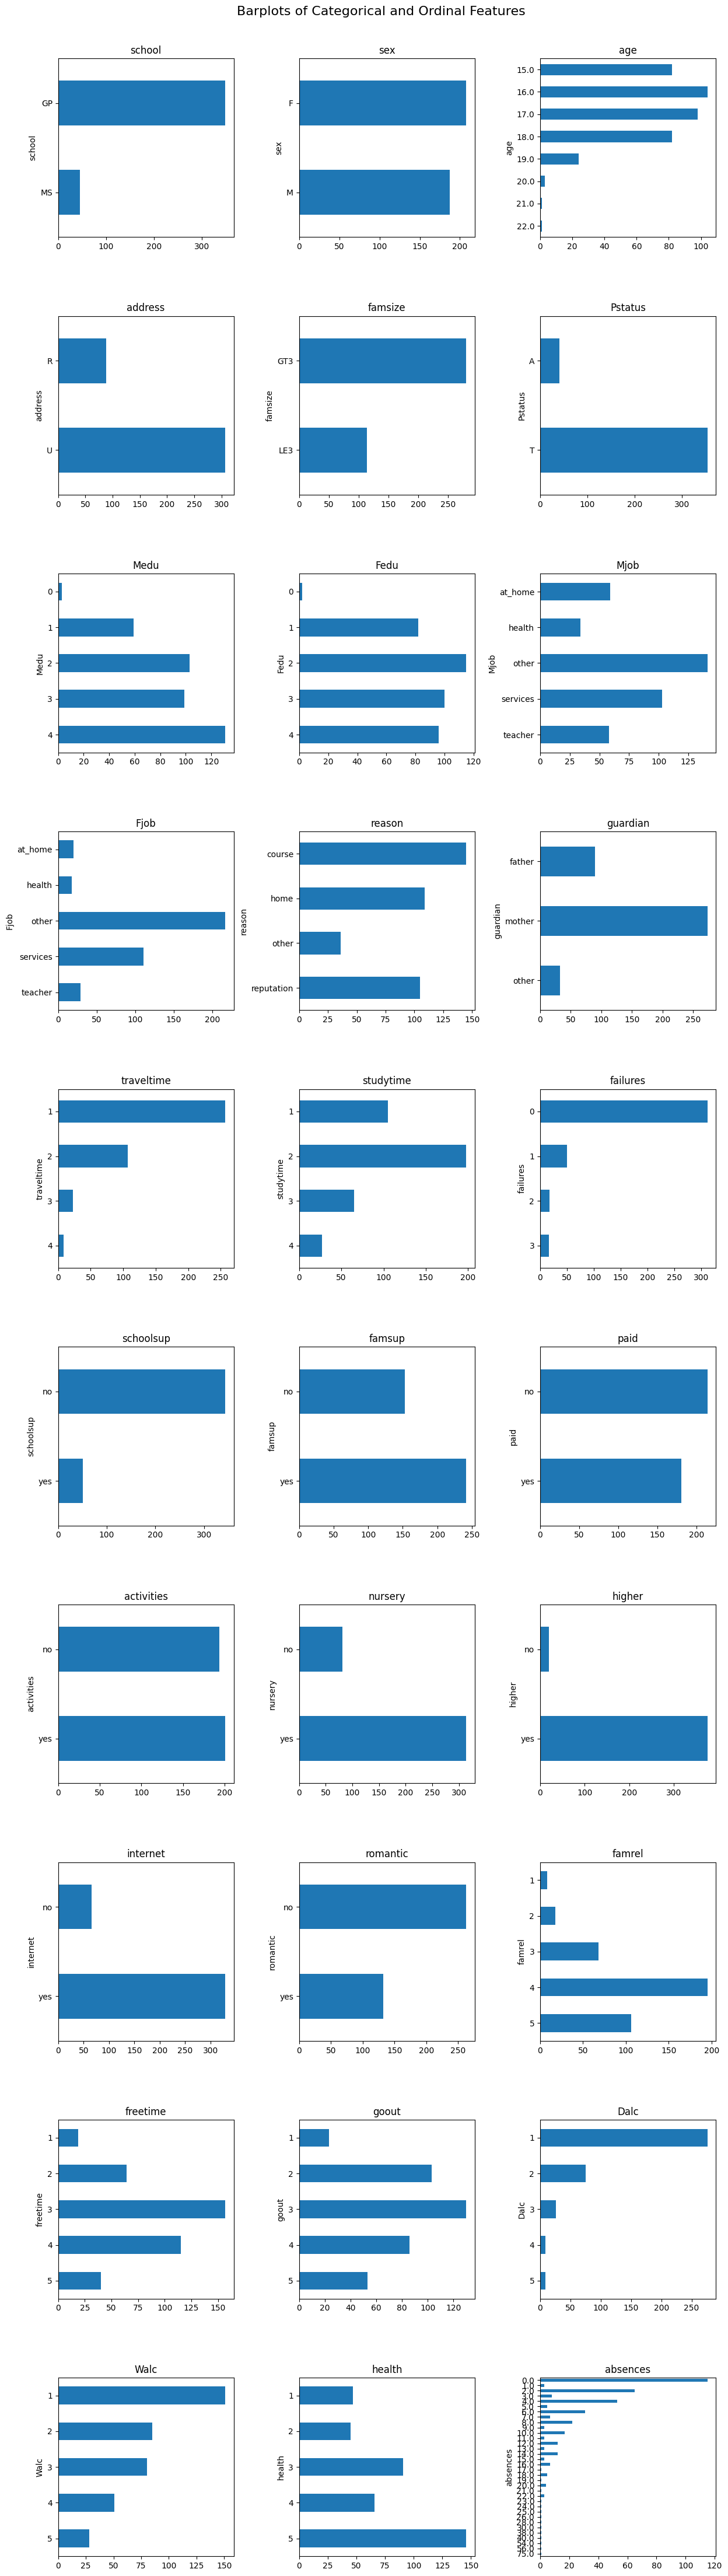

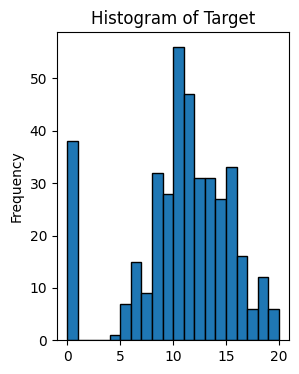

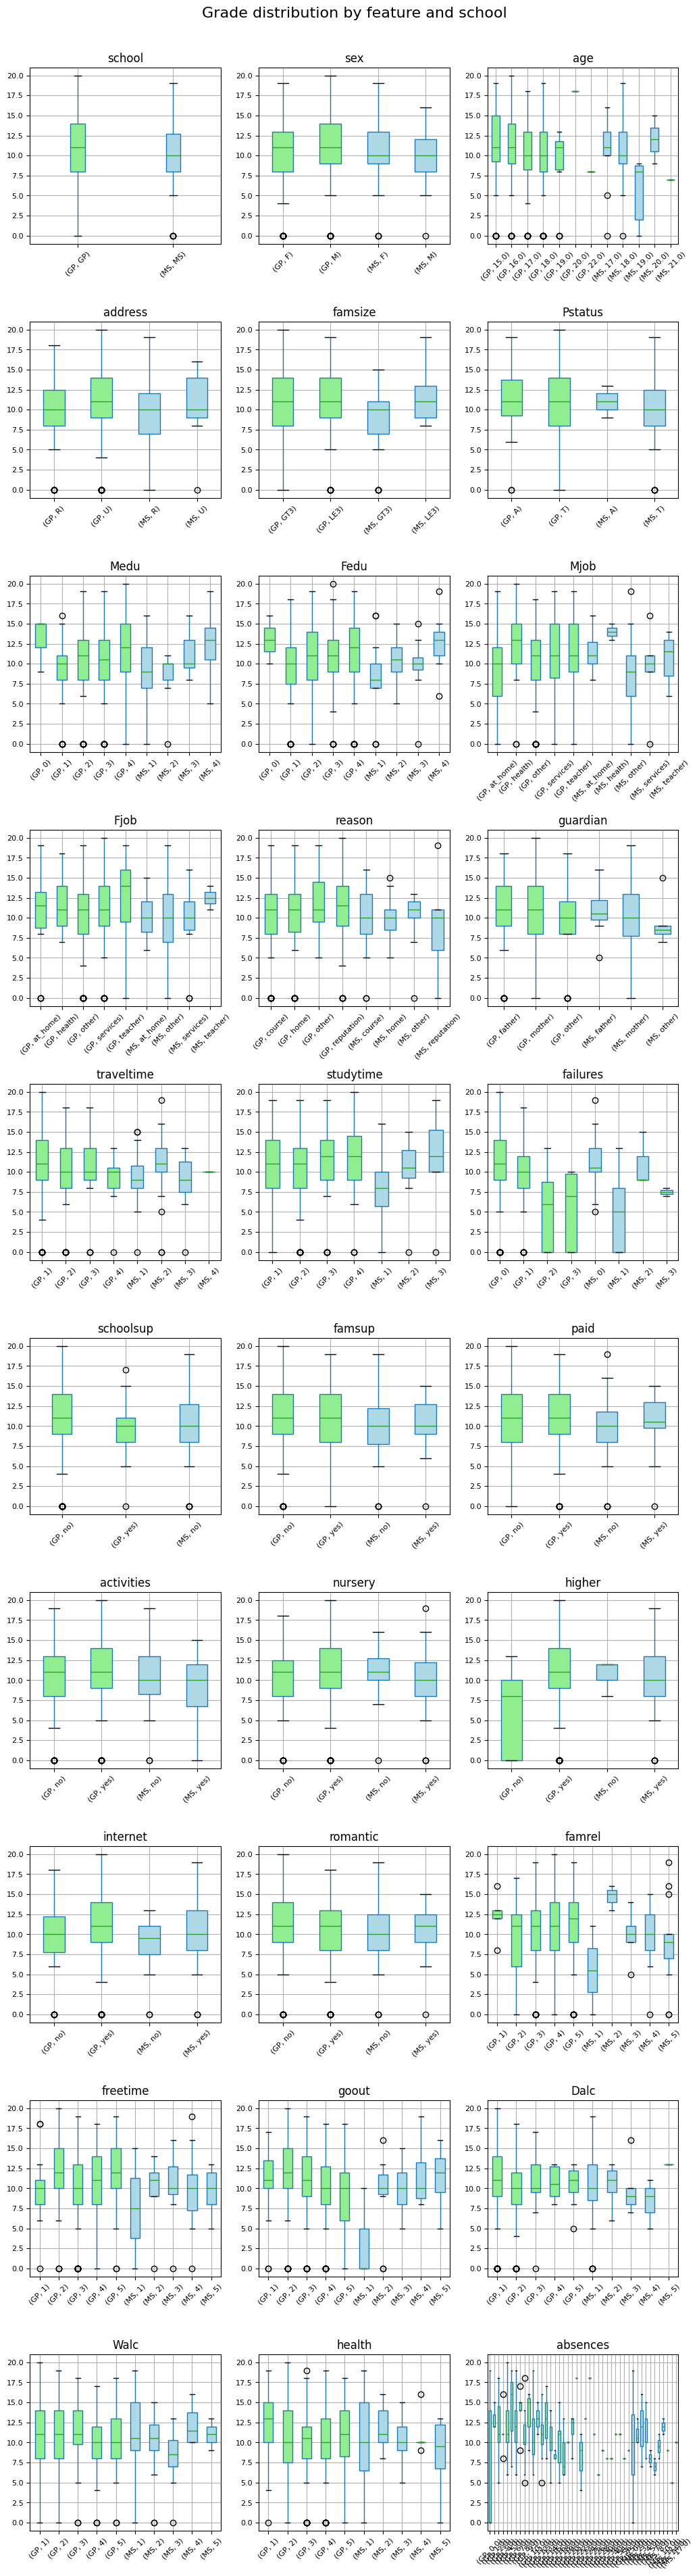

In [8]:
make_barplots(X, y)
make_boxplots(X, y)

## Separação treino-teste e modelagem inicial

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

In [10]:
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer

In [11]:
from sklearn.preprocessing import PolynomialFeatures


categorical_features = X.select_dtypes(include=['category']).columns
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns

num_pipeline = Pipeline([
    ('scaler', StandardScaler()),
   ('imputer', SimpleImputer(strategy='mean'))
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(drop='first')),
])

preprocessing_pipeline = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features),
    ],
    remainder='passthrough',
)

pipe = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('regressor', DummyRegressor(strategy='mean')),
])

In [12]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
import numpy as np

# Configuração da validação cruzada e do grid de parâmetros
num_splits = 1000
test_fraction = 0.2
num_samples_total = len(y_train)
num_samples_test = int(test_fraction * num_samples_total)
num_samples_train = num_samples_total - num_samples_test

param_grid = [
    {
        'regressor': [DummyRegressor(strategy='mean')],
    },
    {
        'regressor': [Ridge()],
        'regressor__alpha': np.logspace(-3, 3, 7),
    },
    {
        'regressor': [HistGradientBoostingRegressor()],
        'regressor__max_iter': [100, 300 , 500],
        'regressor__max_depth': [3, 5, 7],
        'regressor__learning_rate': [0.1, 0.05, 0.01],

    },
]
grid = GridSearchCV(
    pipe,
    param_grid,
    cv=ShuffleSplit(
        n_splits=num_splits,
        test_size=num_samples_test,
        random_state=42,
    ),
    n_jobs=-1,
    scoring='neg_root_mean_squared_error',
)

grid.fit(X_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=1000, random_state=42, test_size=63, train_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler()),
                                                                                         ('imputer',
                                                                                          SimpleImputer())]),
                                                                         Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime'...
             n_jobs=-1,
             param_grid=[{'regressor': [DummyRegressor()]},
                         {'regressor': [Ridge()],
                          'regressor__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
                         {'regressor': [HistGradientBoostingRegressor()],
                          'regressor__learning_rate': [0.1, 0.05, 0.01],
                          'regressor__max_depth': [3, 5, 7],
                          'regressor__max_iter': [100, 300, 500]}],
             scoring='neg_root_mean_squared_error')

In [13]:
results_df = pd.DataFrame(grid.cv_results_) \
    .sort_values(by='rank_test_score')

results_df = results_df \
    .set_index(
        results_df["params"] \
            .apply(lambda x: "_".join(str(val) for val in x.values()))
    ) \
    .rename_axis("model")

model_scores = results_df.filter(regex=r"split\d*_test_score")

In [14]:
model_scores.index[0]

'HistGradientBoostingRegressor()_0.01_3_300'

In [15]:
mean_perf = model_scores.agg(['mean', 'std'], axis=1)
mean_perf['std'] = mean_perf['std'] / np.sqrt(num_splits)
mean_perf = mean_perf.sort_values('mean', ascending=False)
mean_perf

,mean,std
model,,
HistGradientBoostingRegressor()_0.01_3_300,-3.992195,0.011068
HistGradientBoostingRegressor()_0.01_3_500,-4.008504,0.011073
HistGradientBoostingRegressor()_0.05_3_100,-4.010567,0.011068
HistGradientBoostingRegressor()_0.01_5_300,-4.020055,0.011142
HistGradientBoostingRegressor()_0.01_7_300,-4.025689,0.011121
HistGradientBoostingRegressor()_0.01_7_100,-4.051759,0.011486
HistGradientBoostingRegressor()_0.01_5_100,-4.052110,0.011503
HistGradientBoostingRegressor()_0.01_5_500,-4.059993,0.011179
HistGradientBoostingRegressor()_0.01_3_100,-4.061079,0.011482


## Comparação de modelos

O código a seguir foi copiado de https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html

In [16]:
import numpy as np

from scipy.stats import t


def corrected_std(differences, n_train, n_test):
    """Corrects standard deviation using Nadeau and Bengio's approach.

    Parameters
    ----------
    differences : ndarray of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    corrected_std : float
        Variance-corrected standard deviation of the set of differences.
    """
    # kr = k times r, r times repeated k-fold crossvalidation,
    # kr equals the number of times the model was evaluated
    kr = len(differences)
    corrected_var = np.var(differences, ddof=1) * (1 / kr + n_test / n_train)
    corrected_std = np.sqrt(corrected_var)
    return corrected_std


def compute_corrected_ttest(differences, df, n_train, n_test):
    """Computes right-tailed paired t-test with corrected variance.

    Parameters
    ----------
    differences : array-like of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    df : int
        Degrees of freedom.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    t_stat : float
        Variance-corrected t-statistic.
    p_val : float
        Variance-corrected p-value.
    """
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = t.sf(np.abs(t_stat), df)  # right-tailed t-test
    return t_stat, p_val

In [17]:
model_1_scores = model_scores.iloc[0].values  # scores of the best model
model_2_scores = model_scores.iloc[1].values  # scores of the second-best model

differences = model_1_scores - model_2_scores

n = differences.shape[0]  # number of test sets
dof = n - 1

t_stat, p_val = compute_corrected_ttest(
    differences,
    dof,
    num_samples_train,
    num_samples_test,
)
print(f"Corrected t-statistic: {t_stat:.3f}")
print(f"Corrected p-value: {p_val:.3f}")

Corrected t-statistic: 0.539
Corrected p-value: 0.295


In [18]:
# Test all models against the best model.
best_model_scores = model_scores.iloc[0].values

n_comparisons = model_scores.shape[0] - 1

pairwise_t_test = []

for model_i in range(1, len(model_scores)):
    model_i_scores = model_scores.iloc[model_i].values
    differences = model_i_scores - best_model_scores
    t_stat, p_val = compute_corrected_ttest(
        differences,
        dof,
        num_samples_train,
        num_samples_test,
    )

    # Implement Bonferroni correction
    p_val *= n_comparisons

    # Bonferroni can output p-values higher than 1
    p_val = 1 if p_val > 1 else p_val

    pairwise_t_test.append([
        model_scores.index[0],
        model_scores.index[model_i],
        t_stat,
        p_val,
    ])

pairwise_comp_df = pd.DataFrame(
    pairwise_t_test,
    columns=["model_1", "model_2", "t_stat", "p_val"],
).round(3)

In [19]:
pairwise_comp_df

,model_1,model_2,t_stat,p_val
0,HistGradientBoostingRegressor()_0.01_3_300,HistGradientBoostingRegressor()_0.01_3_500,-0.539,1.000
1,HistGradientBoostingRegressor()_0.01_3_300,HistGradientBoostingRegressor()_0.05_3_100,-0.568,1.000
2,HistGradientBoostingRegressor()_0.01_3_300,HistGradientBoostingRegressor()_0.01_5_300,-0.868,1.000
3,HistGradientBoostingRegressor()_0.01_3_300,HistGradientBoostingRegressor()_0.01_7_300,-0.985,1.000
4,HistGradientBoostingRegressor()_0.01_3_300,HistGradientBoostingRegressor()_0.01_7_100,-1.059,1.000
5,HistGradientBoostingRegressor()_0.01_3_300,HistGradientBoostingRegressor()_0.01_5_100,-1.059,1.000
6,HistGradientBoostingRegressor()_0.01_3_300,HistGradientBoostingRegressor()_0.01_5_500,-1.314,1.000
7,HistGradientBoostingRegressor()_0.01_3_300,HistGradientBoostingRegressor()_0.01_3_100,-1.139,1.000
8,HistGradientBoostingRegressor()_0.01_3_300,HistGradientBoostingRegressor()_0.05_5_100,-1.306,1.000
9,HistGradientBoostingRegressor()_0.01_3_300,HistGradientBoostingRegressor()_0.01_7_500,-1.390,1.000


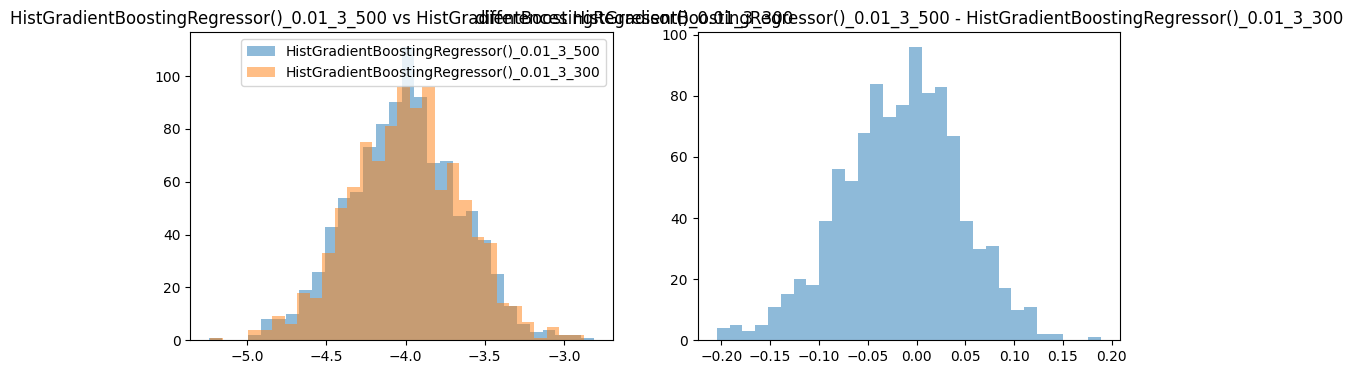

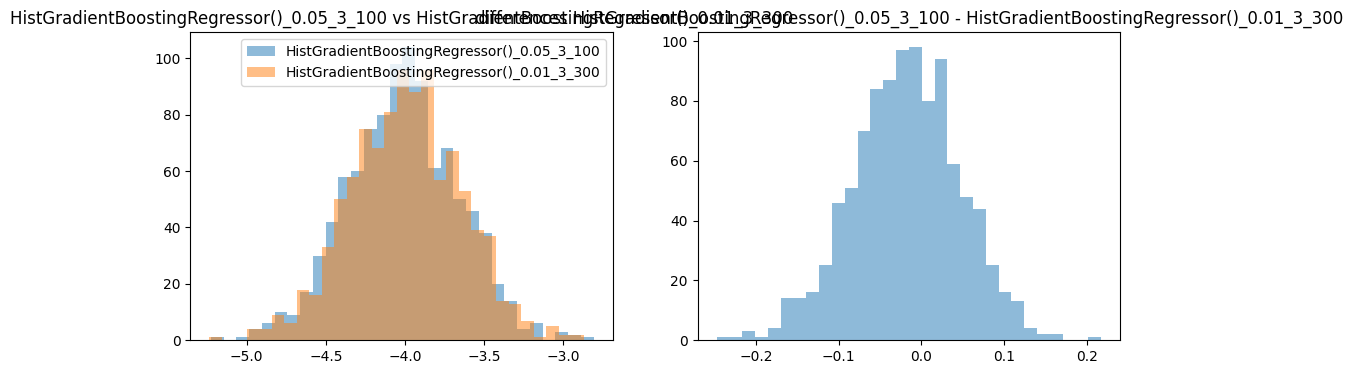

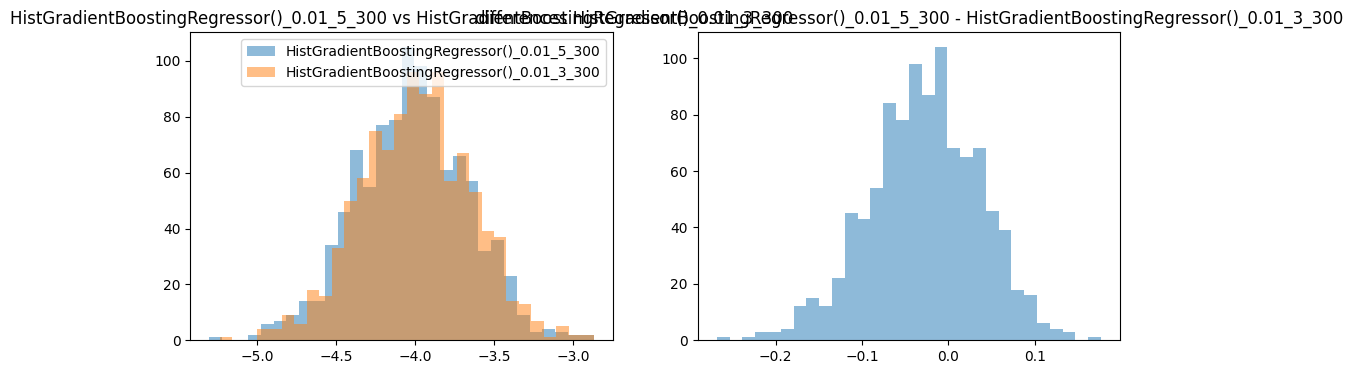

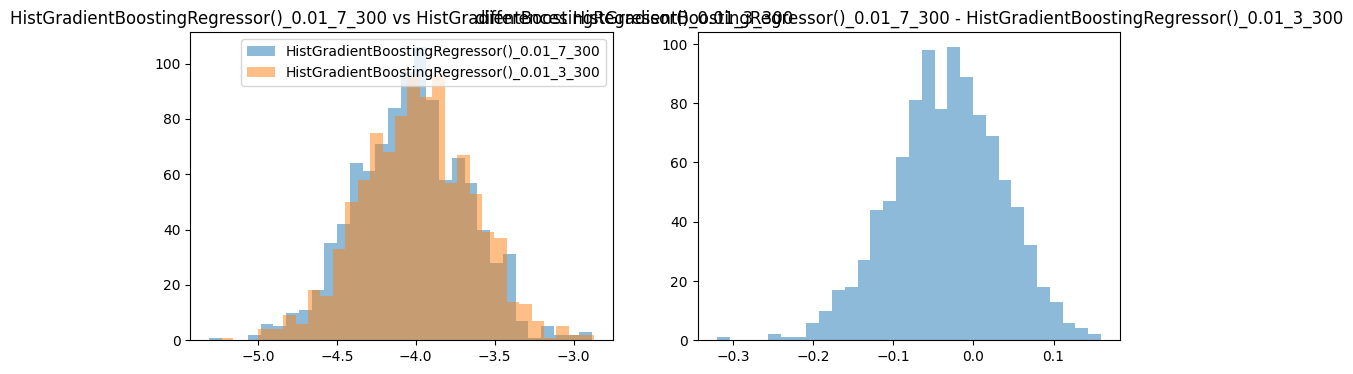

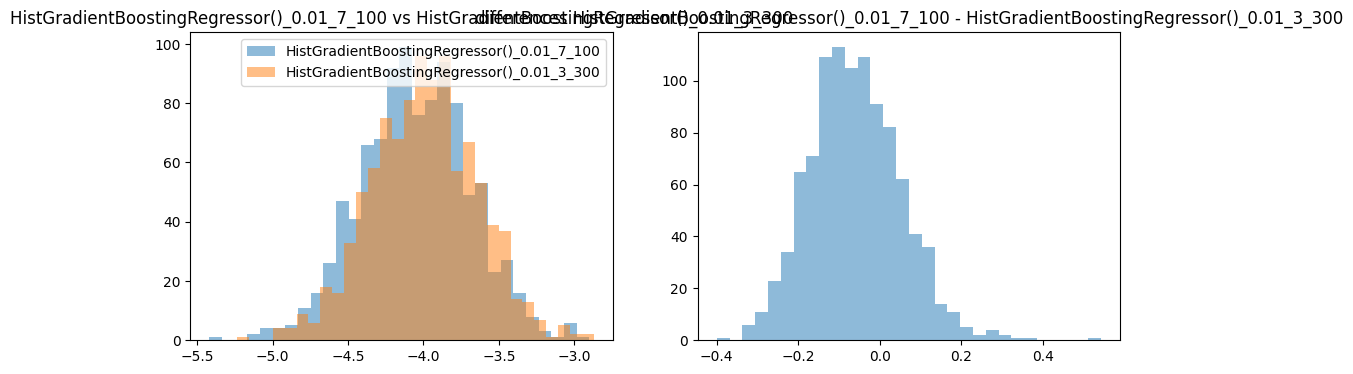

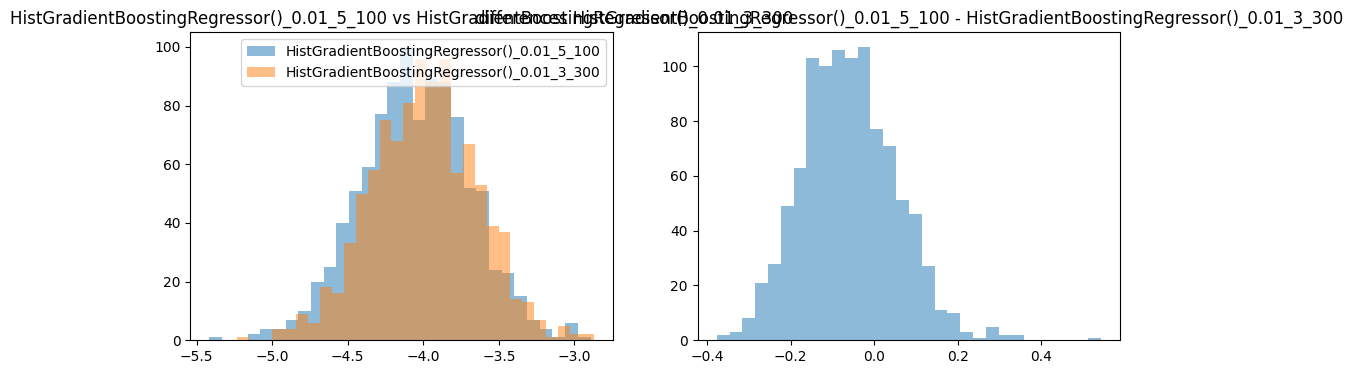

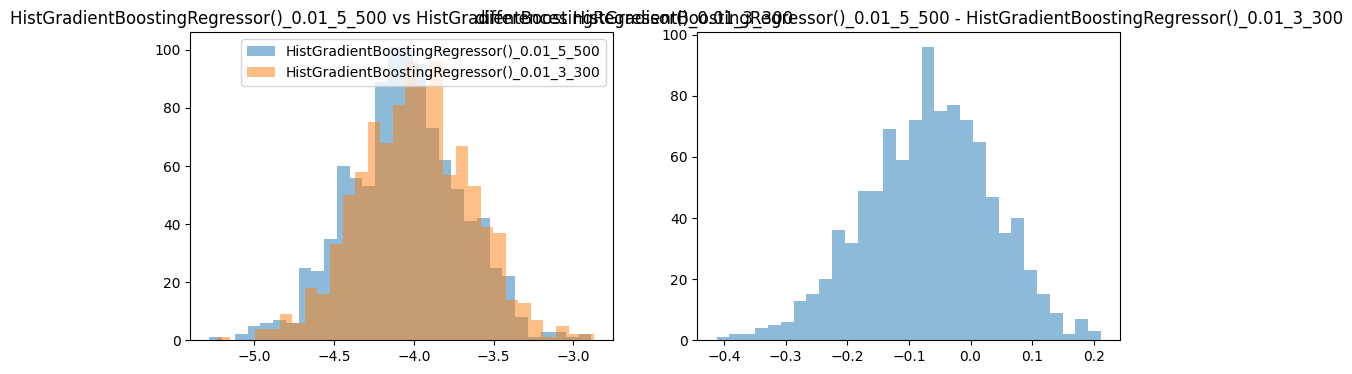

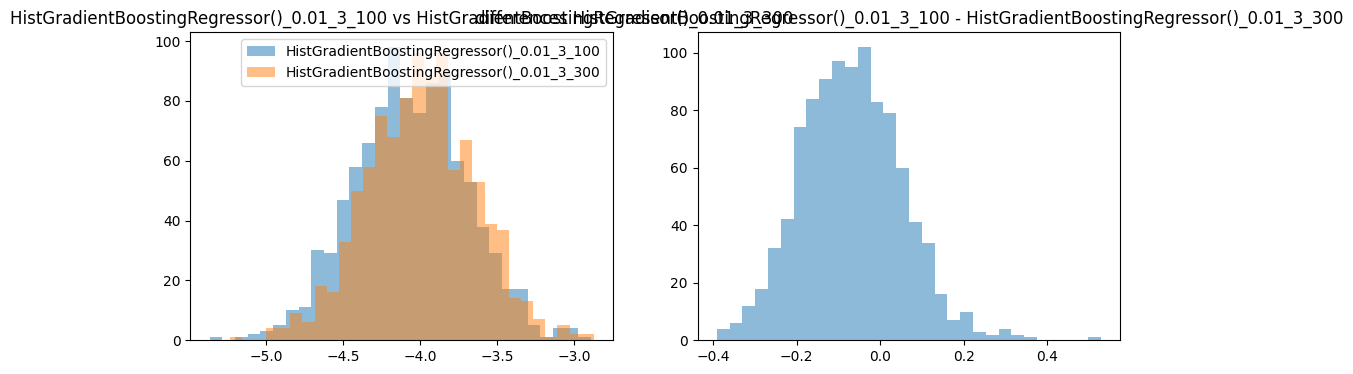

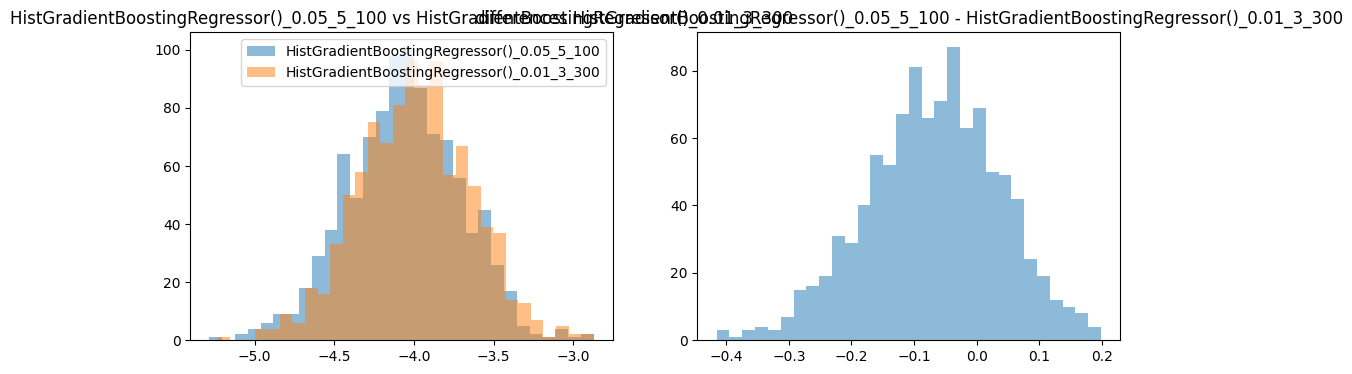

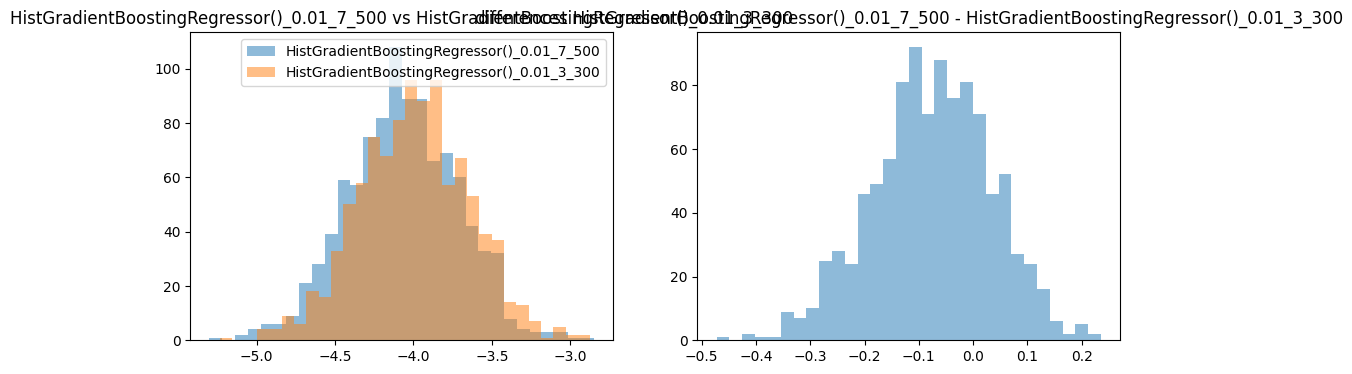

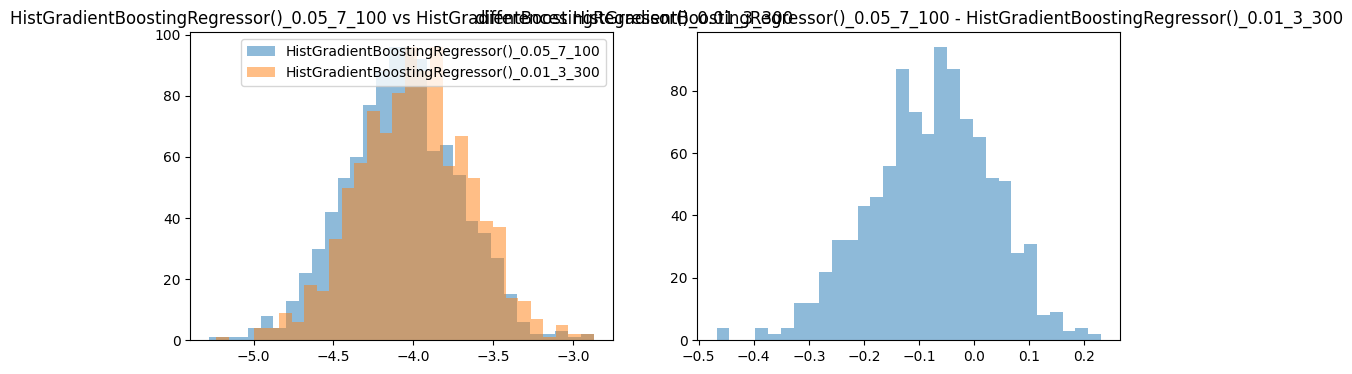

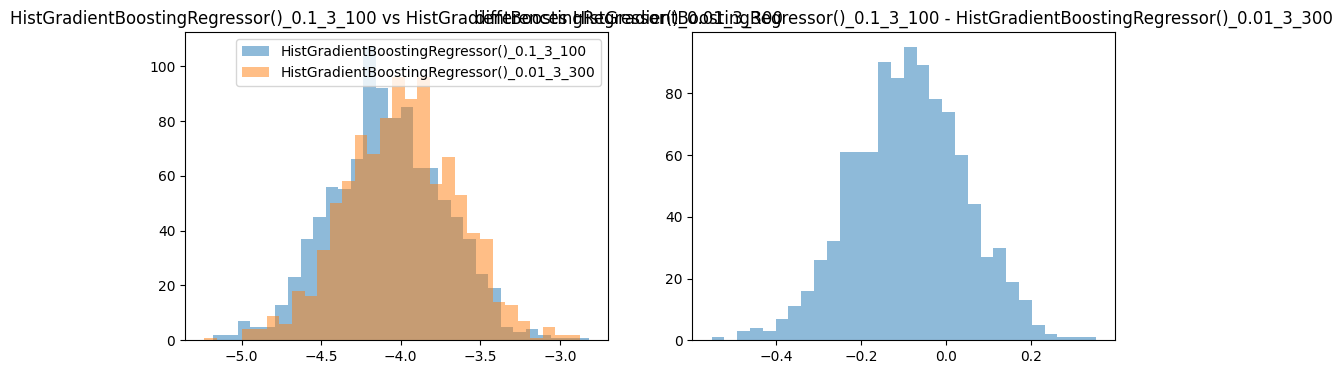

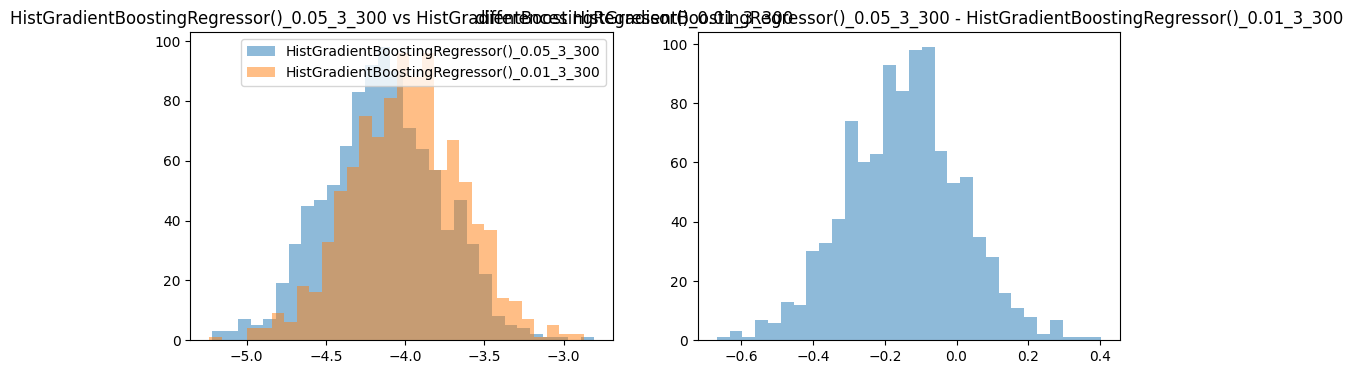

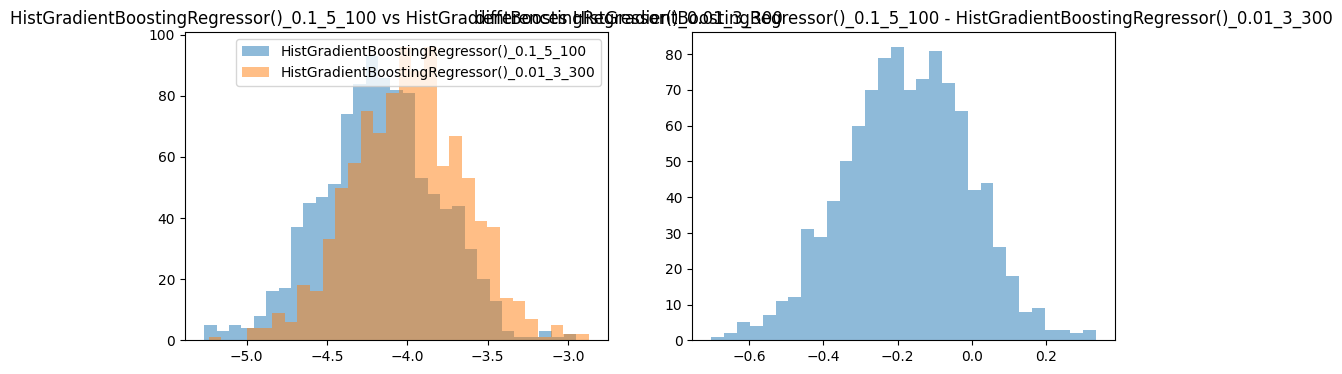

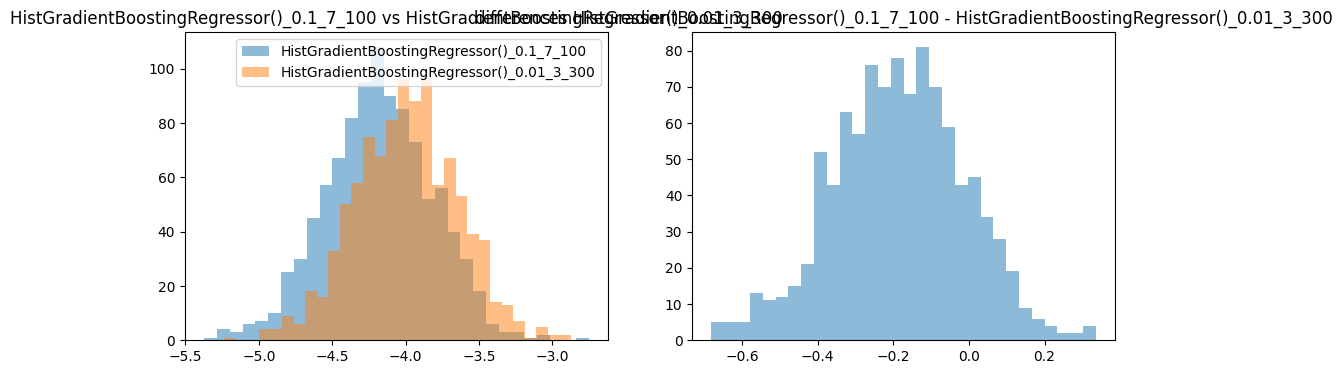

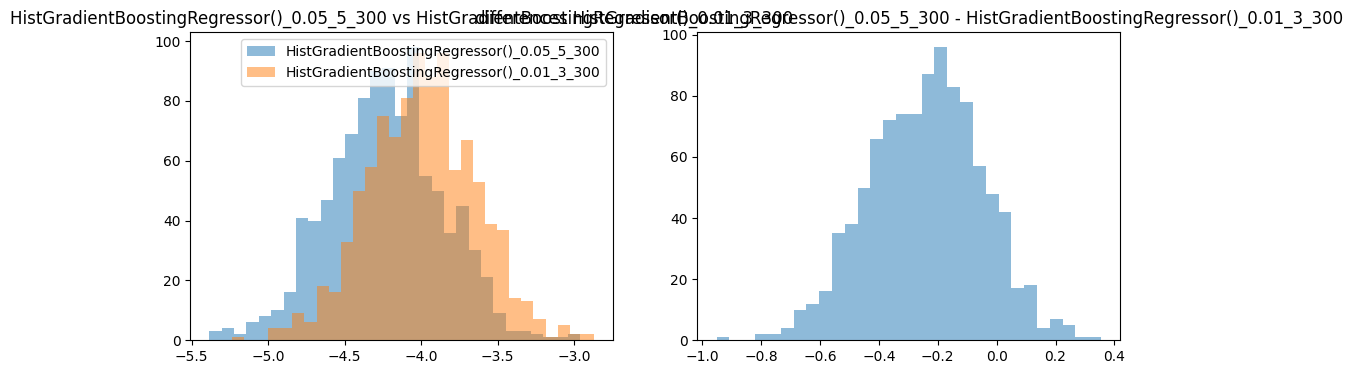

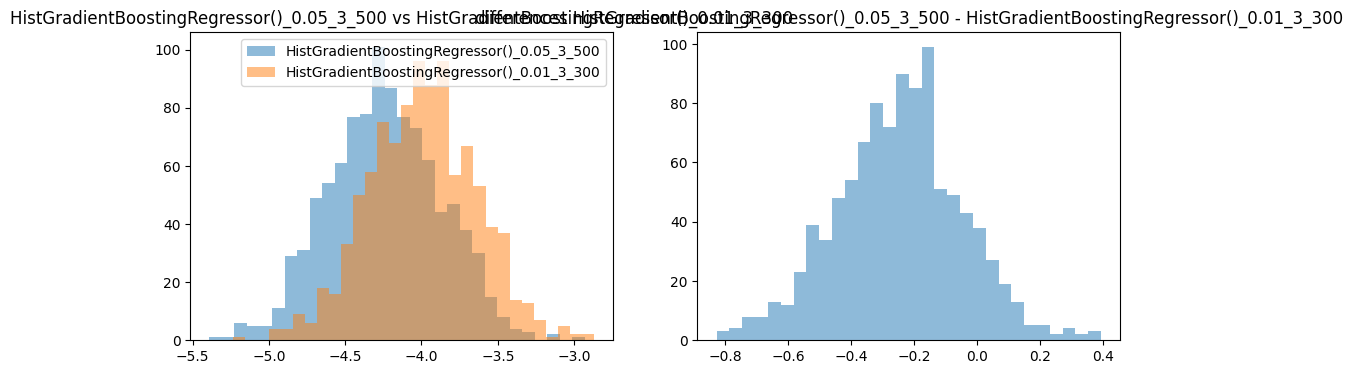

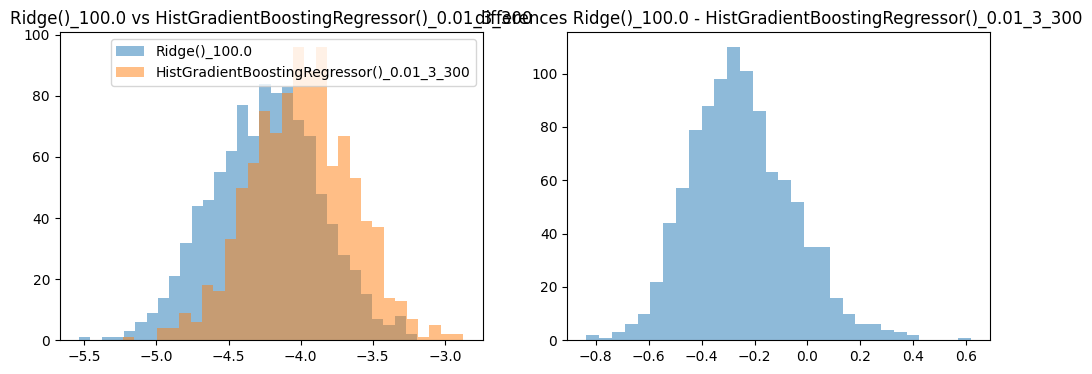

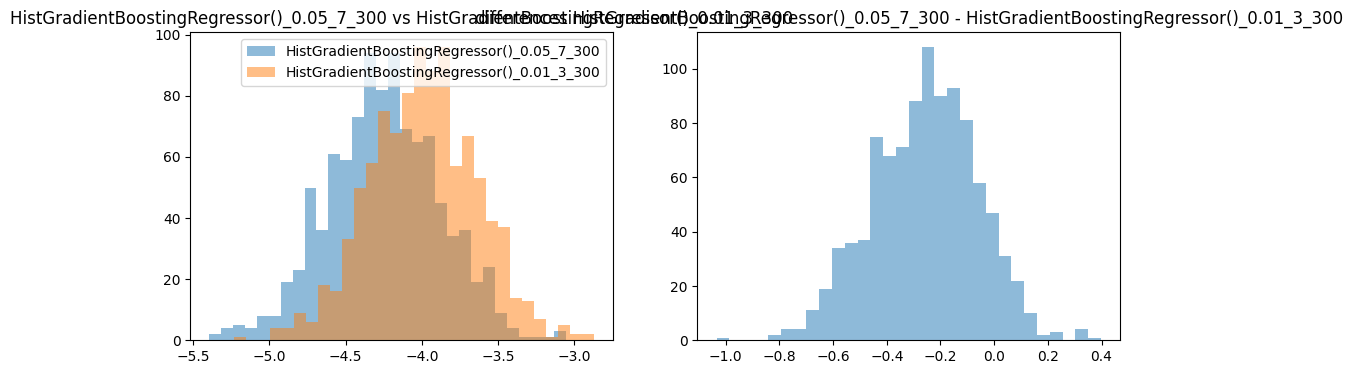

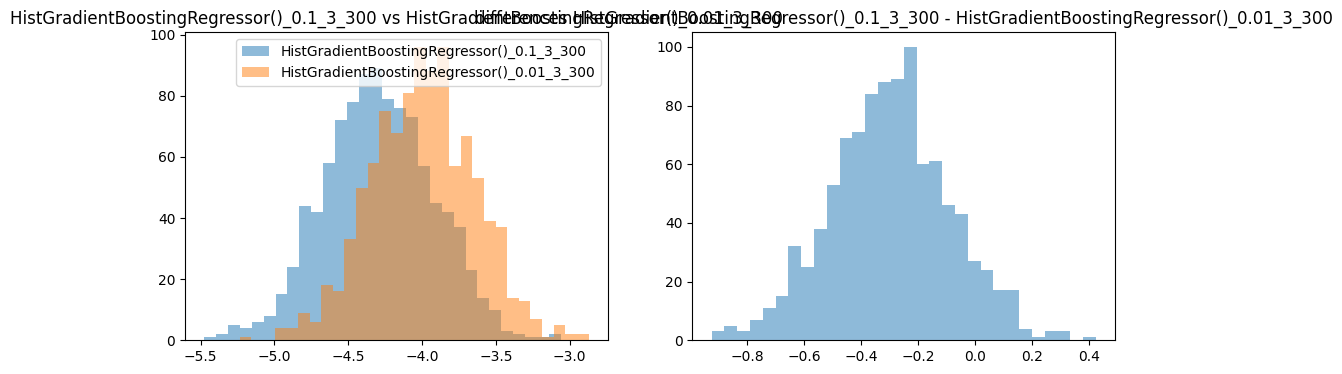

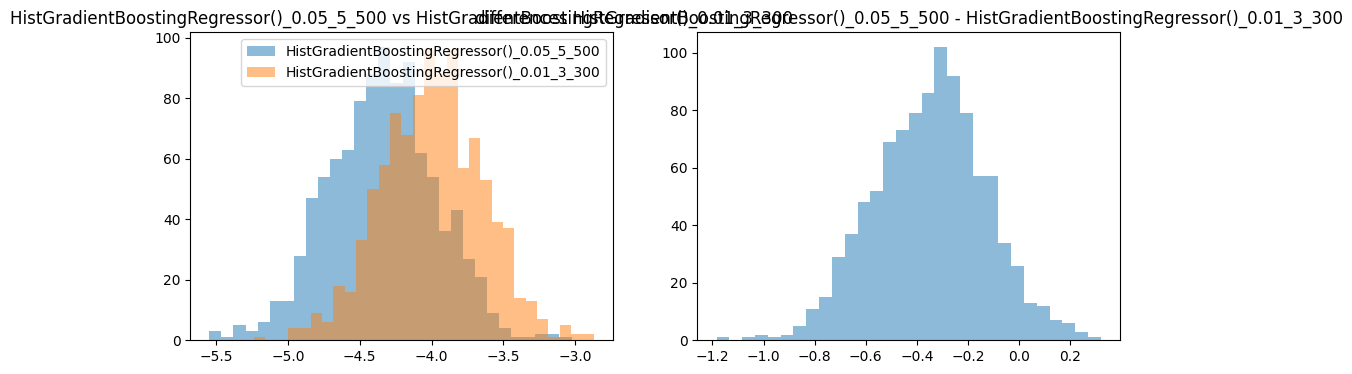

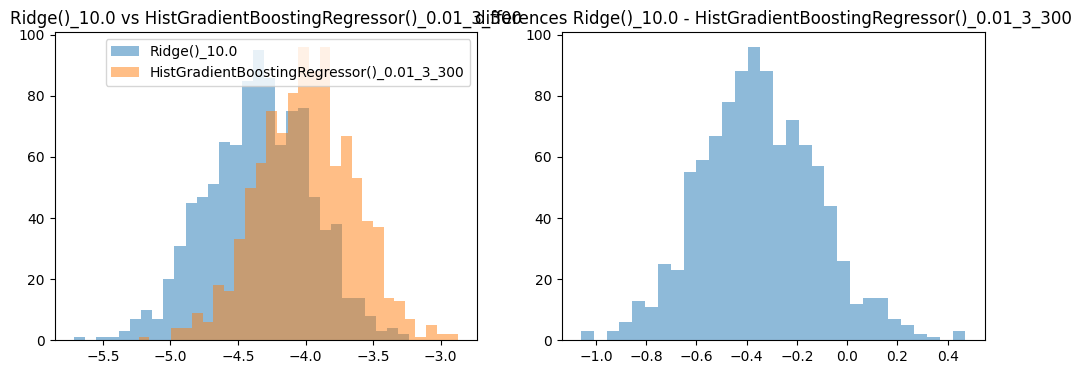

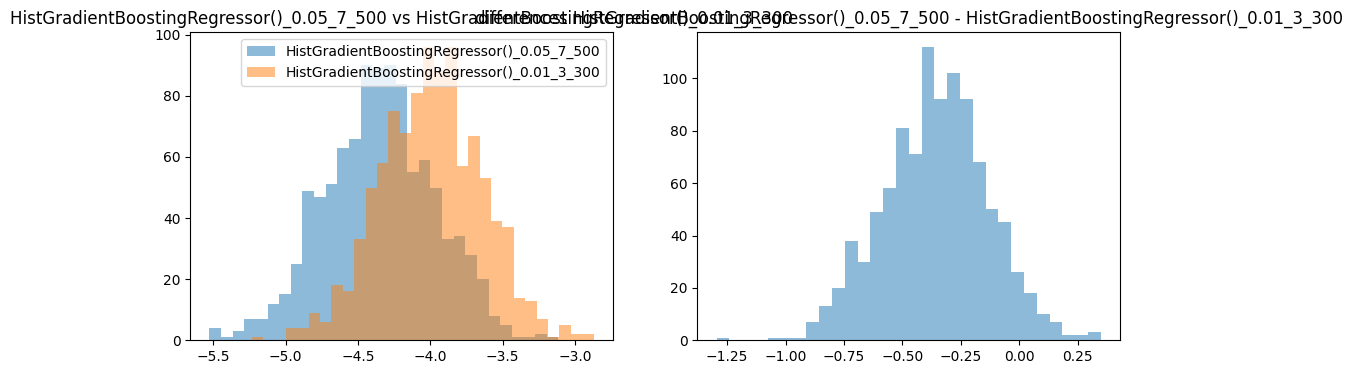

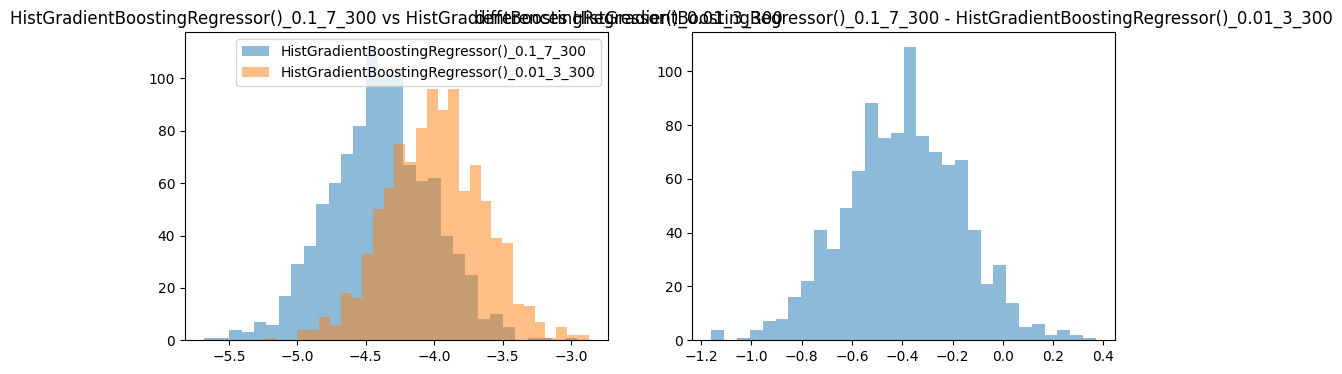

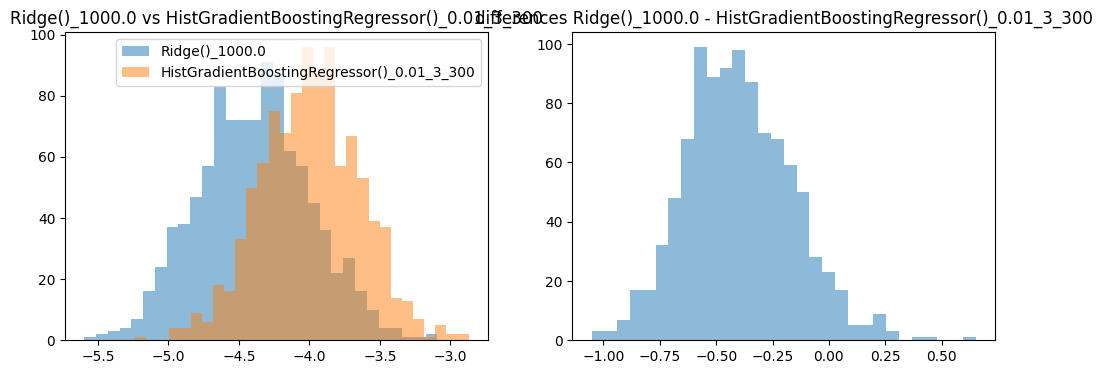

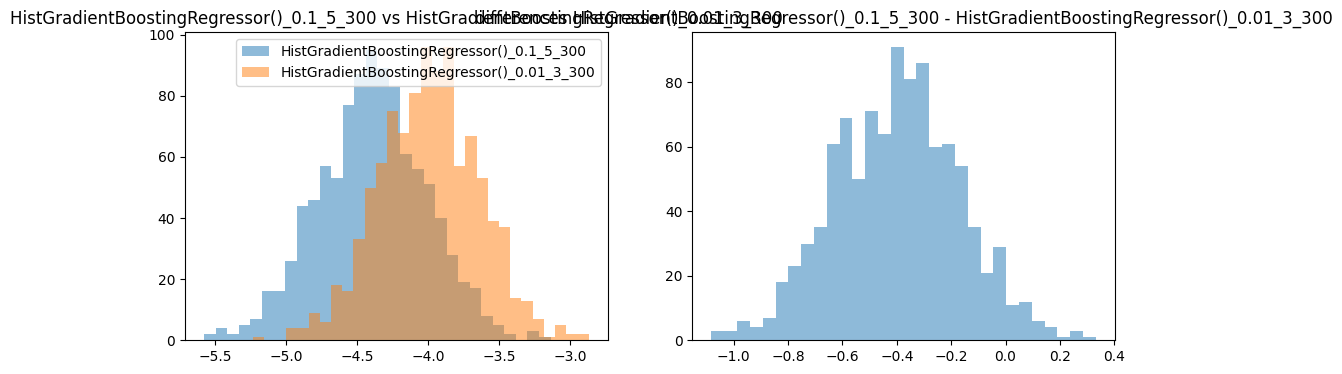

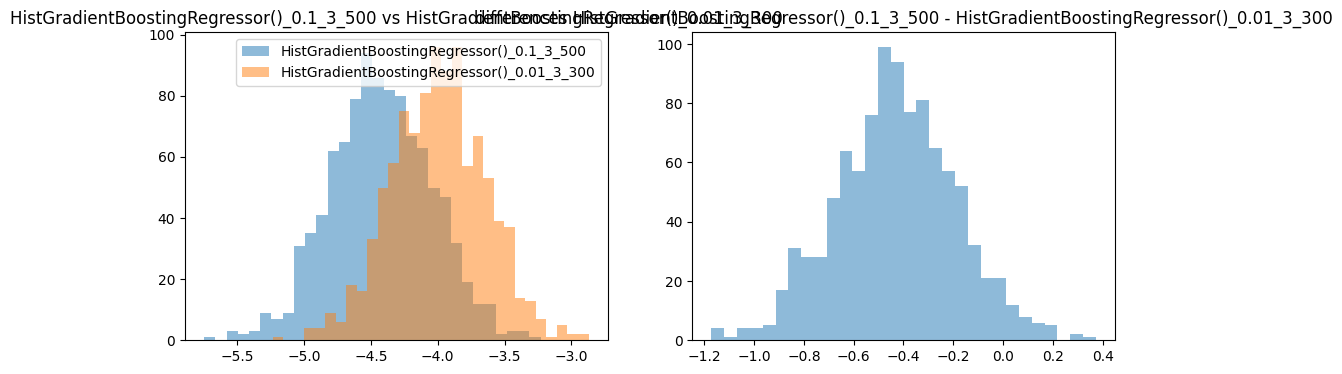

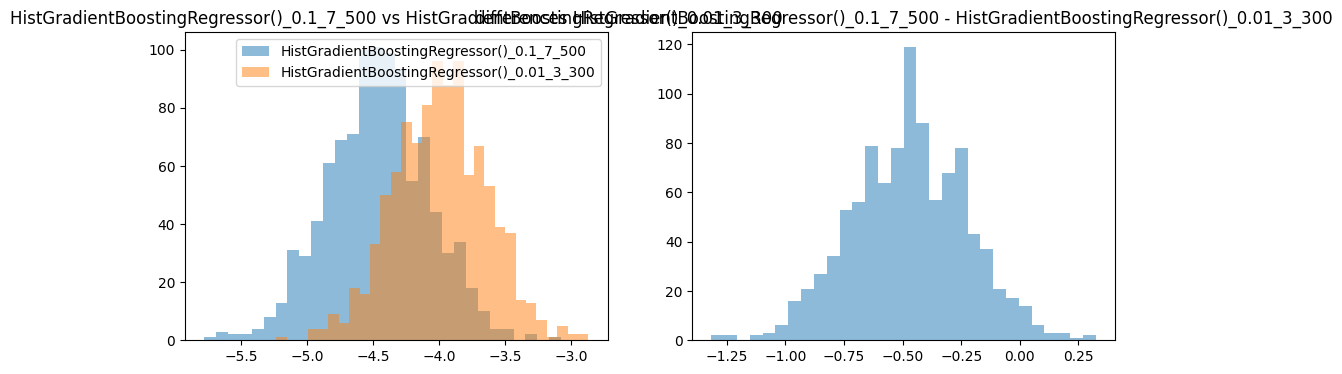

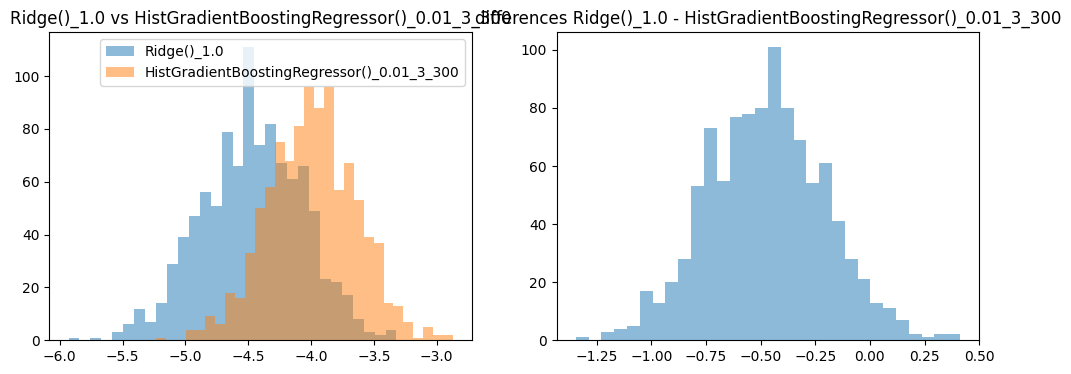

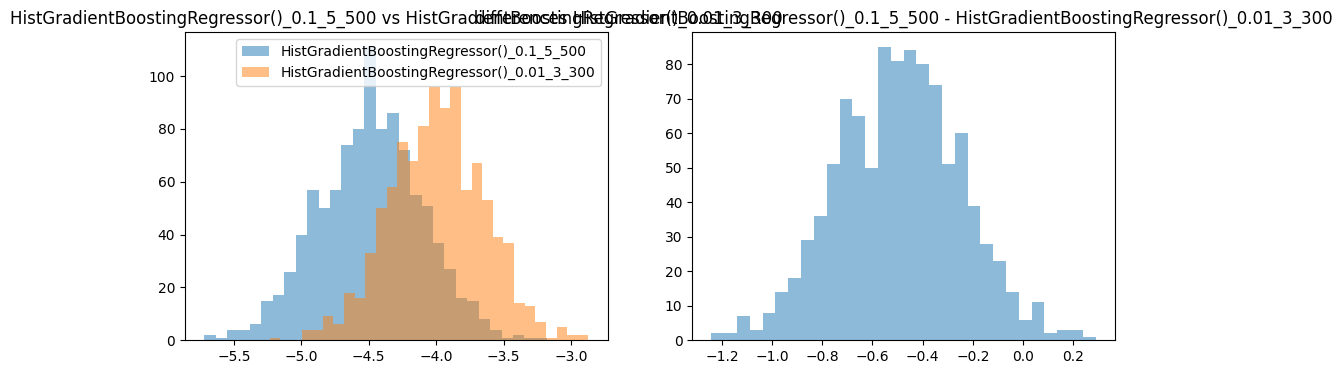

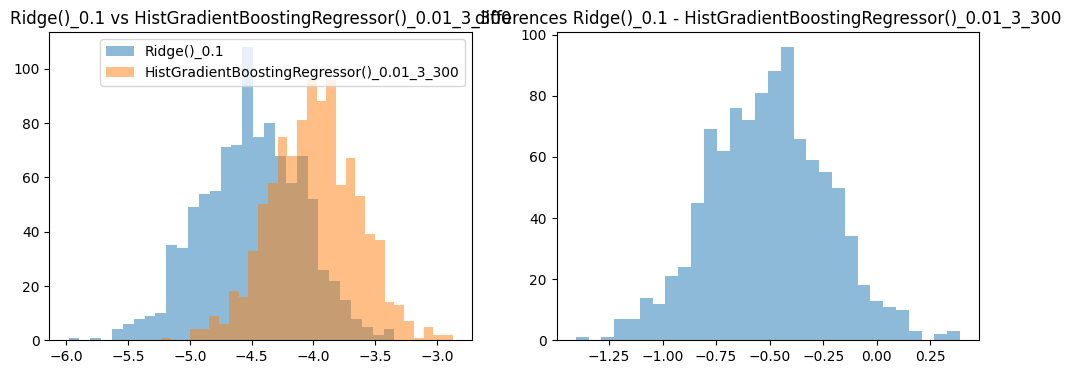

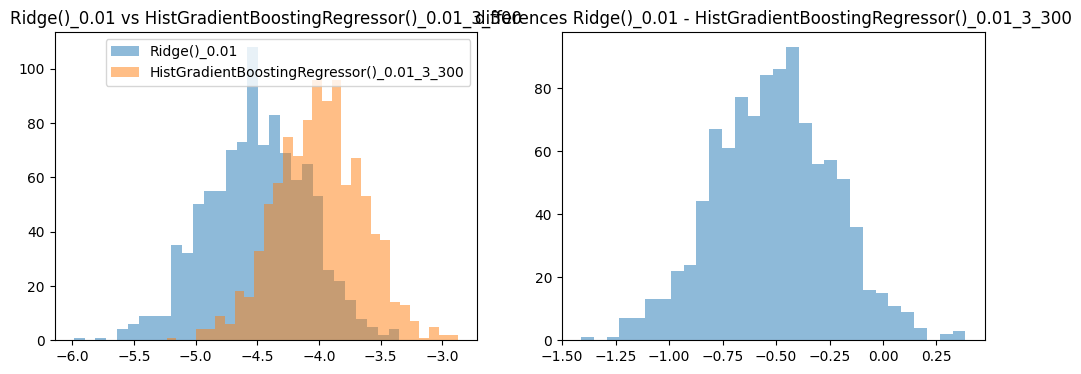

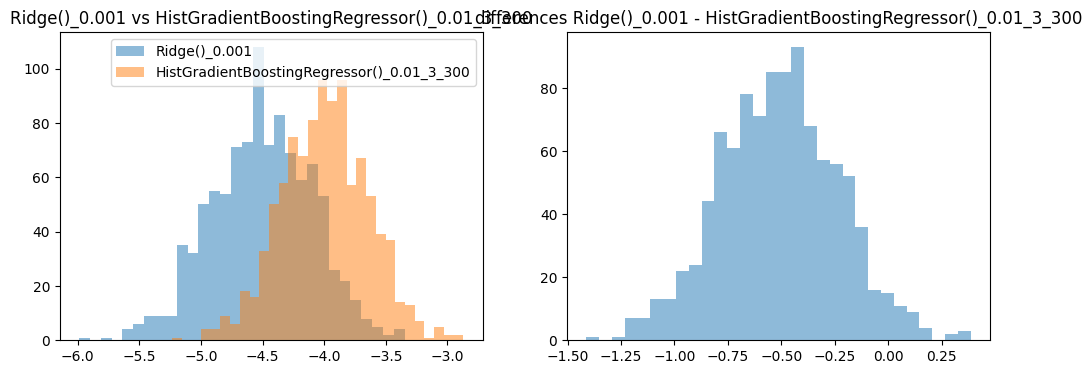

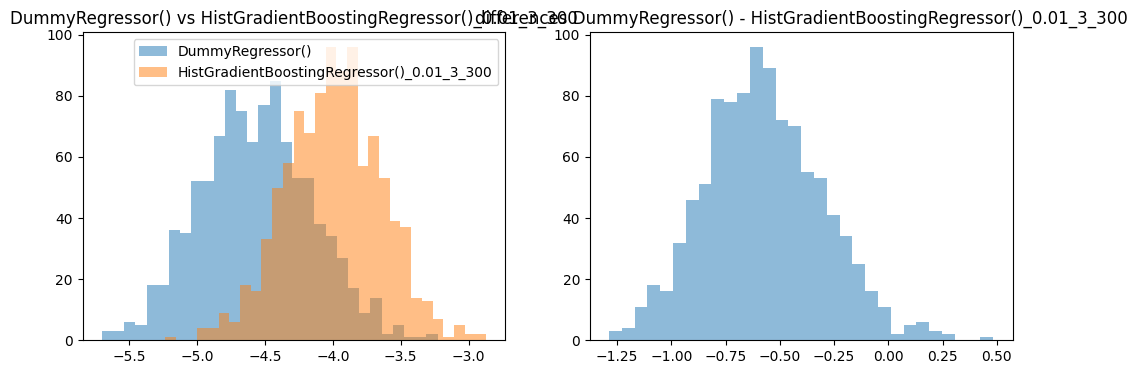

In [20]:
for model_i in range(1, len(model_scores)):
    model_i_scores = model_scores.iloc[model_i].values
    differences = model_i_scores - best_model_scores

    name_i = model_scores.index[model_i]
    name_best = model_scores.index[0]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(model_i_scores, bins=30, alpha=0.5, label=name_i)
    plt.hist(best_model_scores, bins=30, alpha=0.5, label=name_best)
    plt.title(f'{name_i} vs {name_best}')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.hist(differences, bins=30, alpha=0.5)
    plt.title(f'differences {name_i} - {name_best}')
    plt.show()

In [21]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Definir o pipeline com o regressor HistGradientBoostingRegressor
num_pipeline = Pipeline([
    ('scaler', StandardScaler()),
   ('imputer', SimpleImputer(strategy='mean'))
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(drop='first')),
])

preprocessing_pipeline = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features),
    ],
    remainder='passthrough',
)

pipe = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('regressor', HistGradientBoostingRegressor())
])
# Definir os parâmetros para busca em grid
parameters = {
    'regressor__max_iter': [300],
    'regressor__max_depth': [3],
    'regressor__learning_rate': [0.01],
}

# Criar o objeto GridSearchCV
grid_search = GridSearchCV(pipe, parameters)

# Treinar o modelo com os dados de treinamento
best_model = grid_search.fit(X_train, y_train)

C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [23]:
from sklearn.metrics import mean_squared_error


y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse:.4f}')

RMSE: 4.0544


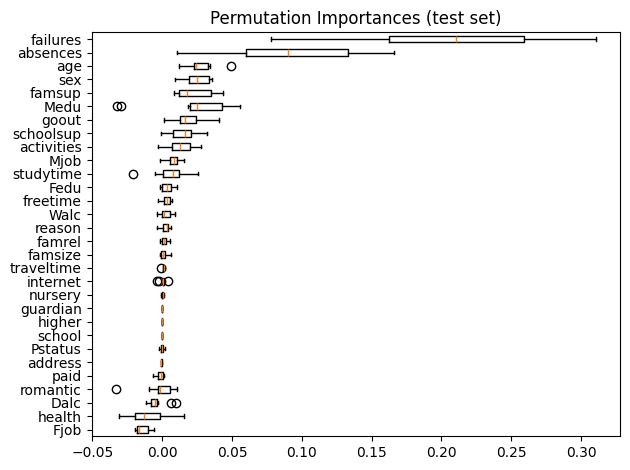

In [24]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Suponha que clf é seu modelo HistGradientBoostingRegressor já treinado
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Organizar os resultados:
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

# Conclusão:

Com base nos resultados apresentados acima (apesar de eu conseguir melhorar o desenho 5% do Dummy), após fazer divesos testes em hiperparâmetros do HistGradientSearch descobri que cada um dos parametros tinham seu limite, e oque se "demonstrou" conseguir se adaptar melhor para a predição foi o HistGradientBoostingRegressor()_0.01_3_300, com 0.01 de taxa de aprendizagem (ou seja uma aprendizagem mais sensivel para o encontro do minimo global), 3 profundidade maxima nas interações (demonstrando que quanto mais profundo os dados pode acabar se ajustando a coisas que não estão diretamente ligada ao nosso target), mesmo acontece quando aumentamos demais o max_iter, que alem de aumentar o risco de sobreajuste do nosso modelo faz ele se ajustar de forma com que perca um pouco o norte de onde é a minimização da função. Ainda que o desempenho do modelo não tenha sido muito melhor do que o esperado, ainda houve uma certa melhora e por fim pode-se analisar que as features mais umportantes na determinação da nota final foi as faltas e quantas vezes a pessoa tinha repetido de ano já.

# Parte 2

## Tratativa pra remoção de alunos que tiveram nota final zero e os alunos que faltaram muito.

In [35]:
def load_data(data_dir: Path = DATA_DIR) -> pd.DataFrame:
    # Read data and fix column types.
    df = pd.read_csv(data_dir / 'data.csv')

    categorical_columns = [
        'school',
        'sex',
        'address',
        'famsize',
        'Pstatus',
        'Mjob',
        'Fjob',
        'reason',
        'guardian',
        'schoolsup',
        'famsup',
        'paid',
        'activities',
        'nursery',
        'higher',
        'internet',
        'romantic',
    ]
    numerical_columns = [
        'age',
        'absences',
        'grade',
    ]
    ordinal_columns = [
        'Medu',
        'Fedu',
        'traveltime',
        'studytime',
        'failures',
        'famrel',
        'freetime',
        'goout',
        'Dalc',
        'Walc',
        'health',
    ]
    for column_group, column_type in (
        (categorical_columns, 'category'),
        (numerical_columns, 'float64'),
        (ordinal_columns, 'int64'),
    ):
        for column in column_group:
            df[column] = df[column].astype(column_type)

    # Split features and target, and return.
    df = df[df['grade']!=0]
    df = df[df['absences']<8] # Usei como critério de corte o valor 8, pois a partir desse valor o grafico de notas começa a apresentar uma fluctuação para baixo.
    X = df.drop(columns=['grade']).copy()
    y = df['grade'].copy()
    return X, y

In [40]:
X,y = load_data()
X.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences
count,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000
mean,16.481928,2.726908,2.554217,1.445783,2.092369,0.192771,4.000000,3.240964,3.056225,1.401606,2.212851,3.582329,2.526104
std,1.205111,1.141995,1.098970,0.694210,0.858721,0.604909,0.847197,0.982800,1.041890,0.792707,1.243886,1.417862,2.179524
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,15.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000
50%,16.000000,3.000000,3.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000
75%,17.000000,4.000000,4.000000,2.000000,3.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,4.000000
max,21.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,7.000000


In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

In [44]:
categorical_features = X.select_dtypes(include=['category']).columns
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns

num_pipeline = Pipeline([
    ('scaler', StandardScaler()),
   ('imputer', SimpleImputer(strategy='mean'))
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(drop='first')),
])

preprocessing_pipeline = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features),
    ],
    remainder='passthrough',
)

pipe = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('regressor', DummyRegressor(strategy='mean')),
])

In [45]:
# Configuração da validação cruzada e do grid de parâmetros
num_splits = 1000
test_fraction = 0.2
num_samples_total = len(y_train)
num_samples_test = int(test_fraction * num_samples_total)
num_samples_train = num_samples_total - num_samples_test

param_grid = [
    {
        'regressor': [DummyRegressor(strategy='mean')],
    },
    {
        'regressor': [Ridge()],
        'regressor__alpha': np.logspace(-3, 3, 7),
    },
    {
        'regressor': [HistGradientBoostingRegressor()],
        'regressor__max_iter': [100, 300 , 500],
        'regressor__max_depth': [3, 5, 7],
        'regressor__learning_rate': [0.1, 0.05, 0.01],

    },
]
grid = GridSearchCV(
    pipe,
    param_grid,
    cv=ShuffleSplit(
        n_splits=num_splits,
        test_size=num_samples_test,
        random_state=42,
    ),
    n_jobs=-1,
    scoring='neg_root_mean_squared_error',
)

grid.fit(X_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=1000, random_state=42, test_size=39, train_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler()),
                                                                                         ('imputer',
                                                                                          SimpleImputer())]),
                                                                         Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime'...
             n_jobs=-1,
             param_grid=[{'regressor': [DummyRegressor()]},
                         {'regressor': [Ridge()],
                          'regressor__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
                         {'regressor': [HistGradientBoostingRegressor()],
                          'regressor__learning_rate': [0.1, 0.05, 0.01],
                          'regressor__max_depth': [3, 5, 7],
                          'regressor__max_iter': [100, 300, 500]}],
             scoring='neg_root_mean_squared_error')

In [48]:
results_df = pd.DataFrame(grid.cv_results_) \
    .sort_values(by='rank_test_score')

results_df = results_df \
    .set_index(
        results_df["params"] \
            .apply(lambda x: "_".join(str(val) for val in x.values()))
    ) \
    .rename_axis("model")

model_scores = results_df.filter(regex=r"split\d*_test_score")

In [49]:
mean_perf = model_scores.agg(['mean', 'std'], axis=1)
mean_perf['std'] = mean_perf['std'] / np.sqrt(num_splits)
mean_perf = mean_perf.sort_values('mean', ascending=False)
mean_perf

,mean,std
model,,
HistGradientBoostingRegressor()_0.01_3_500,-2.764560,0.008621
HistGradientBoostingRegressor()_0.05_3_100,-2.766677,0.008628
HistGradientBoostingRegressor()_0.01_7_300,-2.769128,0.008613
HistGradientBoostingRegressor()_0.01_5_300,-2.769163,0.008617
HistGradientBoostingRegressor()_0.01_7_500,-2.771968,0.008614
HistGradientBoostingRegressor()_0.01_5_500,-2.772059,0.008624
HistGradientBoostingRegressor()_0.05_7_100,-2.772779,0.008634
HistGradientBoostingRegressor()_0.05_5_100,-2.772844,0.008640
Ridge()_10.0,-2.777629,0.008135


In [50]:
model_1_scores = model_scores.iloc[0].values  # scores of the best model
model_2_scores = model_scores.iloc[1].values  # scores of the second-best model

differences = model_1_scores - model_2_scores

n = differences.shape[0]  # number of test sets
dof = n - 1

t_stat, p_val = compute_corrected_ttest(
    differences,
    dof,
    num_samples_train,
    num_samples_test,
)
print(f"Corrected t-statistic: {t_stat:.3f}")
print(f"Corrected p-value: {p_val:.3f}")

Corrected t-statistic: 0.267
Corrected p-value: 0.395


In [51]:
# Test all models against the best model.
best_model_scores = model_scores.iloc[0].values

n_comparisons = model_scores.shape[0] - 1

pairwise_t_test = []

for model_i in range(1, len(model_scores)):
    model_i_scores = model_scores.iloc[model_i].values
    differences = model_i_scores - best_model_scores
    t_stat, p_val = compute_corrected_ttest(
        differences,
        dof,
        num_samples_train,
        num_samples_test,
    )

    # Implement Bonferroni correction
    p_val *= n_comparisons

    # Bonferroni can output p-values higher than 1
    p_val = 1 if p_val > 1 else p_val

    pairwise_t_test.append([
        model_scores.index[0],
        model_scores.index[model_i],
        t_stat,
        p_val,
    ])

pairwise_comp_df = pd.DataFrame(
    pairwise_t_test,
    columns=["model_1", "model_2", "t_stat", "p_val"],
).round(3)

In [52]:
pairwise_comp_df

,model_1,model_2,t_stat,p_val
0,HistGradientBoostingRegressor()_0.01_3_500,HistGradientBoostingRegressor()_0.05_3_100,-0.267,1.000
1,HistGradientBoostingRegressor()_0.01_3_500,HistGradientBoostingRegressor()_0.01_7_300,-0.145,1.000
2,HistGradientBoostingRegressor()_0.01_3_500,HistGradientBoostingRegressor()_0.01_5_300,-0.146,1.000
3,HistGradientBoostingRegressor()_0.01_3_500,HistGradientBoostingRegressor()_0.01_7_500,-0.253,1.000
4,HistGradientBoostingRegressor()_0.01_3_500,HistGradientBoostingRegressor()_0.01_5_500,-0.257,1.000
5,HistGradientBoostingRegressor()_0.01_3_500,HistGradientBoostingRegressor()_0.05_7_100,-0.281,1.000
6,HistGradientBoostingRegressor()_0.01_3_500,HistGradientBoostingRegressor()_0.05_5_100,-0.284,1.000
7,HistGradientBoostingRegressor()_0.01_3_500,Ridge()_10.0,-0.175,1.000
8,HistGradientBoostingRegressor()_0.01_3_500,HistGradientBoostingRegressor()_0.01_3_300,-0.461,1.000
9,HistGradientBoostingRegressor()_0.01_3_500,Ridge()_100.0,-0.443,1.000


In [53]:
# Definir o pipeline com o regressor HistGradientBoostingRegressor
num_pipeline = Pipeline([
    ('scaler', StandardScaler()),
   ('imputer', SimpleImputer(strategy='mean'))
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(drop='first')),
])

preprocessing_pipeline = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features),
    ],
    remainder='passthrough',
)

pipe = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('regressor', HistGradientBoostingRegressor())
])
# Definir os parâmetros para busca em grid
parameters = {
    'regressor__max_iter': [500],
    'regressor__max_depth': [3],
    'regressor__learning_rate': [0.01],
}

# Criar o objeto GridSearchCV
grid_search = GridSearchCV(pipe, parameters)

# Treinar o modelo com os dados de treinamento
best_model2 = grid_search.fit(X_train, y_train)

In [54]:
y_pred = best_model2.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse:.4f}')

RMSE: 3.1150


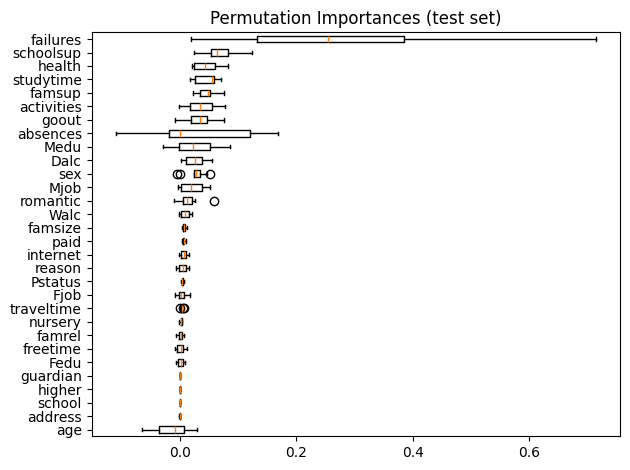

In [55]:
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

# Conclusão

Após a modificação para remover notas zero e alunos que faltavam mais de 8 vezes, o desempenho do modelo melhorou significantemente porém ainda sim comparado com o Dummy regressor vemos uma melhora de aproximadamante uns 5% novamente. Mas mantendo os mesmos comentarios anteriores.